In [5]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: Timeout('Failed to perform, curl: (28) Connection timed out after 10006 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


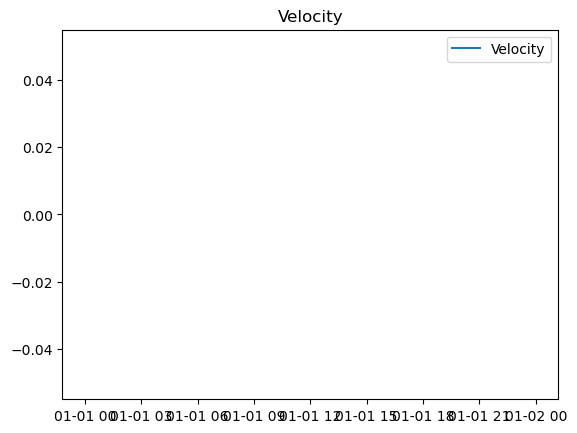

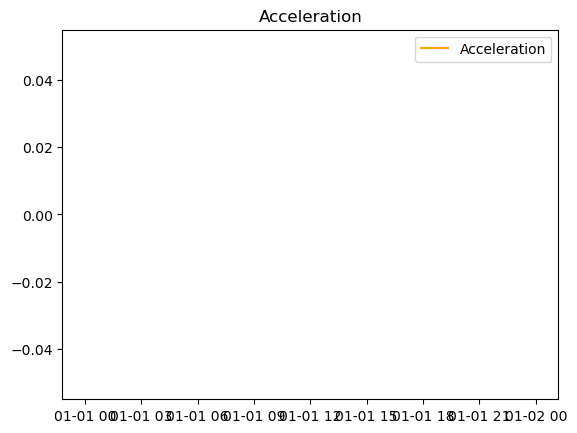

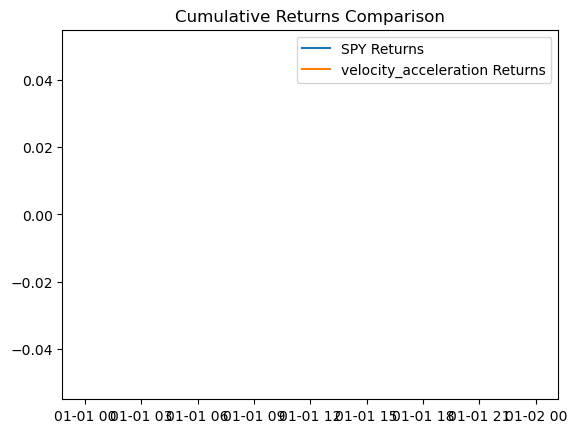

Price,Adj Close,Close,High,Low,Open,Volume,Velocity,Acceleration,signal,strategy,Asset_returns,strategy_returns
Date,,,,,,,,,,,,


In [4]:
ticker = "SPY"
LOOKBACK = -1000

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def add_velocity_acceleration(df):
    velocity = df['Close'].diff()
    acceleration = velocity.diff()

    df['Velocity'] = velocity
    df['Acceleration'] = acceleration

    plt.plot(df['Velocity'], label='Velocity')
    plt.legend()
    plt.title('Velocity')
    plt.figure()  
    plt.plot(df['Acceleration'], label='Acceleration', color='orange')
    plt.legend()
    plt.title('Acceleration')   

    return df.dropna()

def strategy(df):
    # 1. Create purely Buy (1) and Sell (-1) signals, use NaN for "do nothing"
    conditions = [
        (df['Velocity'] > 0) & (df['Acceleration'] > 0).astype(bool), # Condition 1: Short
        (df['Velocity'] > 0) & (df['Acceleration'] < 0).astype(bool)   # Condition 2: Long
    ]
    choices = [1, 0]
    
    # Use np.select to assign 1 or -1, but default to NaN (np.nan) instead of 0
    df['signal'] = np.select(conditions, choices, default=np.nan)

    # 2. Forward Fill (The Memory)
    # This says: "If today is NaN, copy yesterday's position."
    df['strategy'] = df['signal'].ffill()

    # 3. Handle the start (replace initial NaNs with 0)
    df['strategy'] = df['strategy'].fillna(0)

    # 4. Shift to trade "tomorrow"
    df['strategy'] = df['strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='velocity_acceleration Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = add_velocity_acceleration(df)
    df = strategy(df)
    df = test_strategy(df)
    return df

main()